In [1]:
import numpy as np
# import gym

import matplotlib

import matplotlib.pyplot as plt



In [2]:
import gymnasium as gym
from gymnasium.envs.toy_text.frozen_lake import generate_random_map

In [19]:
env = gym.make("FrozenLake-v1", desc=generate_random_map(size=16), render_mode="human", is_slippery=True)
print(type(env))
state, info = env.reset(seed=42)

action_space_size = env.action_space.n
stat_space_size = env.observation_space.n

state = env.reset()[0] 
# print("Initial state:", state)
action = env.action_space.sample()
# get feedback from the environment

obvervation, reward, done, done1, info = env.step(action)
print("observation:", obvervation, "reward:", reward, "done:", done, "done1", done1, "info:", info)

<class 'gymnasium.wrappers.time_limit.TimeLimit'>
observation: 0 reward: 0.0 done: False done1 False info: {'prob': 0.3333333333333333}


In [5]:
# take a look
done = False
state = env.reset()

while not done:
    # randomly pick an action
    action = env.action_space.sample()
    # get feedback from the environment
    
    obvervation, reward, done, done1, info = env.step(action)
    print('action: {}, state: {}, reward: {}'.format(action, obvervation, round(reward, 10)))
    # show the environment
    env.render()

action: 0, state: 0, reward: 0.0
action: 0, state: 16, reward: 0.0
action: 0, state: 32, reward: 0.0
action: 1, state: 33, reward: 0.0


In [7]:
# SARSA parameters
alpha = 0.1   # learning rate #Explains how much we value the new information compared to the information we already have
gamma = 0.9  # discount factor #Explains how much we value future rewards compared to the immediate reward

# Training parameters
n_episodes = 10  #explain how many times we want to run the environment
n_max_steps = 1000   # maximum number of steps per episode

# Exploration / Exploitation parameters
epsilon = 1.0
start_epsilon = 1.0  # start training by selecting purely random actions
min_epsilon = 0.001  # the lowest epsilon allowed to decay to
decay_rate = 0.00001

In [8]:
Qtable = np.zeros((stat_space_size, action_space_size)) #initialize the Q table with zeros
Qtable

array([[0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       ...,
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.]])

In [9]:
# This is our acting policy (epsilon-greedy), which selects an action for exploration/exploitation during training
def epsilon_greedy(Qtable, state, epsilon):
    # Generate a random number and compare to epsilon, if lower then explore, otherwise exploit
    randnum = np.random.uniform(0, 1)
    if randnum < epsilon:
        action = env.action_space.sample()    # explore
        # action = 2
    else:
        action = np.argmax(Qtable[state, :])  # exploit
        # action = env.action_space.sample()
        
    return action
    # return state

In [10]:
# This function is to update the Qtable.
def update_Q(Qtable, state, action, reward, next_state, next_action):
    # 𝑄(𝑆𝑡,𝐴𝑡)=𝑄(𝑆𝑡,𝐴𝑡)+𝛼[𝑅𝑡+1+𝛾𝑄(𝑆𝑡+1,𝐴𝑡+1)−𝑄(𝑆𝑡,𝐴𝑡)]
    Qtable[state][action] = Qtable[state][action] + alpha * (reward + gamma * (Qtable[next_state][next_action]) - Qtable[state][action])
    # Qtable[state, action] += alpha * (reward + gamma * Qtable[next_state, next_action] - Qtable[state, action])
    return Qtable

In [12]:
# Linear Decay Epsilon
def Calculate_epsilon_Linear(epsilon, min_epsilon, decay_rate):
    epsilon = (start_epsilon - min_epsilon) * np.exp(-decay_rate * episode)
    epsilon = max(min_epsilon, epsilon)
    return epsilon

In [13]:
# Exponential Decay Epsilon
def Calculate_epsilon_Exponential(epsilon, min_epsilon, decay_rate):
    # epsilon = epsilon * np.exp(-decay_rate * episode)
    # epsilon = max(min_epsilon, epsilon)
    # return epsilon
    # decay_rate = 0.00001
    decay_factor = (min_epsilon/ start_epsilon)**(1/(n_episodes-1)) #  n_episodes or n_max_steps
    return epsilon * decay_factor

In [14]:
# Discrete Interval Decay Epsilon
def Calculate_epsilon_Discrete_Interval(epsilon, min_epsilon, decay_rate):
    if episode % 100 == 0:
        epsilon = epsilon * np.exp(-decay_rate * episode)
        epsilon = max(min_epsilon, epsilon)
    return epsilon

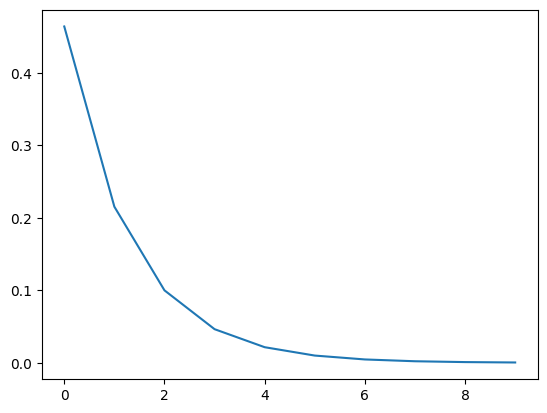

In [15]:
# plot the epsilon decay in 1000 episodes
epsilon = start_epsilon
epsilon_list = []
for episode in range(n_episodes):
    epsilon = Calculate_epsilon_Exponential(epsilon, min_epsilon, decay_rate)
    epsilon_list.append(epsilon)
plt.plot(epsilon_list)
plt.show()

# # Training

In [22]:

def train(n_episodes, n_max_steps, start_epsilon, min_epsilon, decay_rate, Qtable):
    epsilon = 1.
    # reward_array = np.zeros(n_episodes)
    for episode in range(n_episodes):
        # Reset the environment at the start of each episode
        state = env.reset()[0] 

        t = 0
        total_rewards = 0
        done = False
        done1 = False
        # Calculate epsilon value based on decay rate  #decrice the epsilon value
        # epsilon = max(min_epsilon, (start_epsilon - min_epsilon)*np.exp(-decay_rate*episode))
        epsilon = Calculate_epsilon_Exponential(epsilon, min_epsilon, decay_rate)
        
        # Choose an action using previously defined epsilon-greedy policy
        action = epsilon_greedy(Qtable, state, epsilon)  # for first action
        
        # Loop until max number of steps per episode is reached or until the agent reaches the goal (done)        
        for t in range(n_max_steps):
             
            # Perform the action in the environment, get reward and next state
            next_state, reward, done, done1, info = env.step(action)
            
            reward = -10 if reward == 0 else (-1000 if reward < 0 else 1000)

            total_rewards += reward
           
            
            # Choose next action
            next_action=epsilon_greedy(Qtable, next_state, epsilon)
            
            # Update Q-table
            Qtable = update_Q(Qtable, state, action, reward, next_state, next_action)
            
            # Update current state 
            state = next_state
            action = next_action
            
            # Finish the episode when done=True, i.e., reached the goal or fallen into a hole
            if done or done1:
                # reward_array[t] = reward
                break
            # epsilon = max(min_epsilon, (start_epsilon - min_epsilon)*np.exp(-decay_rate*episode)) ## result ==> actions = 0
            
                
    # Return final Q-table
    print("total_rewards",total_rewards)
    return Qtable

In [ ]:
# Train
Qtable = train(n_episodes, n_max_steps, start_epsilon, min_epsilon, decay_rate, Qtable)
# Show Q-table
Qtable

In [ ]:
done = False

current_state, info = env.reset()

while not done:
    action = np.argmax(Qtable[current_state])
    current_state, reward, terminated, truncated, info = env.step(action)
    if terminated or truncated:
        done = not done